<a href="https://colab.research.google.com/github/MahdiTouiser/MahdiTouiser/blob/main/ACA_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
import time
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load image from disk
def load_image(file_path):
    img = cv2.imread(file_path ,cv2.IMREAD_GRAYSCALE )
    if img is None:
        raise FileNotFoundError(f"Error: Unable to load image from path '{file_path}'.")
    return img.astype(np.float32) / 255.0


In [ ]:
# Save image to disk
def save_image(file_path, img):
    img = (img * 255.0).astype(np.uint8)
    cv2.imwrite(file_path, img)


In [ ]:
# CUDA Sobel kernel
@cuda.jit
def sobel_kernel(input_img, output_img):
    i, j = cuda.grid(2)
    rows, cols = input_img.shape

    if 1 < i < rows - 1 and 1 < j < cols - 1:
        output_img[i, j] = (
            input_img[i - 1, j - 1] + 2 * input_img[i - 1, j] + input_img[i - 1, j + 1] -
            input_img[i + 1, j - 1] - 2 * input_img[i + 1, j] - input_img[i + 1, j + 1]
        )


In [ ]:
# CPU Sobel function (for comparison)
def sobel_cpu(input_img):
    rows, cols = input_img.shape
    output_img = np.zeros_like(input_img)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            output_img[i, j] = (
                input_img[i - 1, j - 1] + 2 * input_img[i - 1, j] + input_img[i - 1, j + 1] -
                input_img[i + 1, j - 1] - 2 * input_img[i + 1, j] - input_img[i + 1, j + 1]
            )

    return output_img


In [ ]:
# Performance evaluation function
def evaluate_performance(img_size , file_path):
    # Load image
    input_image = load_image(file_path)

    # Allocate GPU memory
    d_input_image = cuda.to_device(input_image)
    d_output_image = cuda.device_array_like(input_image)

    # Configure CUDA kernel launch parameters
    block_dim = (16, 16)
    grid_dim_x = (input_image.shape[0] + block_dim[0] - 1) // block_dim[0]
    grid_dim_y = (input_image.shape[1] + block_dim[1] - 1) // block_dim[1]
    grid_dim = (grid_dim_x, grid_dim_y)

    # Launch CUDA kernel
    sobel_kernel[grid_dim, block_dim](d_input_image, d_output_image)
    cuda.synchronize()

    # Copy results back to the CPU
    output_image_gpu = d_output_image.copy_to_host()

    # CPU Sobel
    start_time_cpu = time.time()
    output_image_cpu = sobel_cpu(input_image)
    end_time_cpu = time.time()

    # Display images for visual verification
    visualize_comparison(input_image, output_image_cpu, output_image_gpu)

    # Compare execution times
    print(f"CPU Execution Time: {end_time_cpu - start_time_cpu} seconds")


In [ ]:
# Visual comparison function
def visualize_comparison(original_img, sobel_img_cpu, sobel_img_gpu):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(sobel_img_cpu, cmap='gray')
    plt.title('Sobel CPU')

    plt.subplot(1, 3, 3)
    plt.imshow(sobel_img_gpu, cmap='gray')
    plt.title('Sobel GPU')

    plt.show()


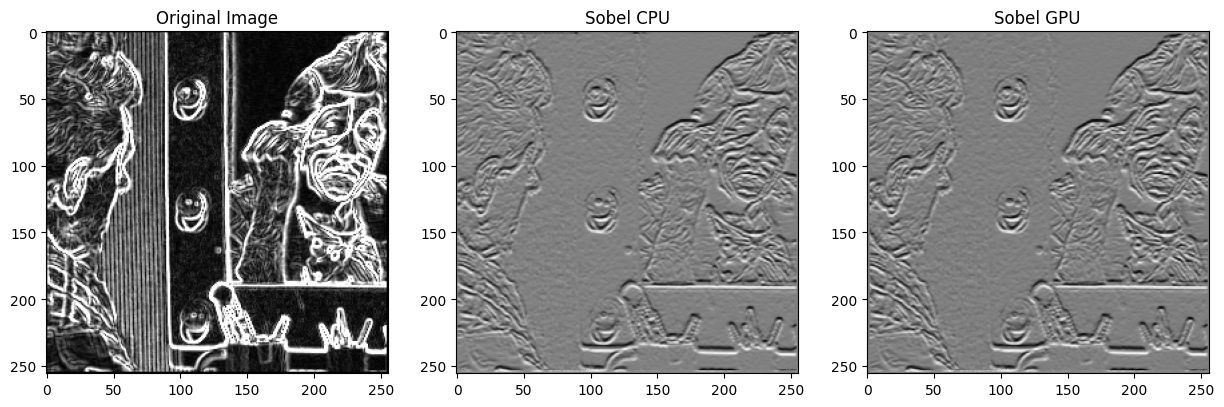

CPU Execution Time: 0.6627366542816162 seconds


In [ ]:
# Main function
import os

def main():
    # Load image
    file_path = os.path.abspath('/content/sample_data/image.jpg')

    input_image = load_image(file_path)

    # Allocate GPU memory
    d_input_image = cuda.to_device(input_image)
    d_output_image = cuda.device_array_like(input_image)

    # Configure CUDA kernel launch parameters
    block_dim = (16, 16)
    grid_dim_x = (input_image.shape[0] + block_dim[0] - 1) // block_dim[0]
    grid_dim_y = (input_image.shape[1] + block_dim[1] - 1) // block_dim[1]
    grid_dim = (grid_dim_x, grid_dim_y)

    # Launch CUDA kernel
    sobel_kernel[grid_dim, block_dim](d_input_image, d_output_image)
    cuda.synchronize()

    # Copy results back to the CPU
    output_image_gpu = d_output_image.copy_to_host()

    # CPU Sobel
    output_image_cpu = sobel_cpu(input_image)

    # Save the results
    save_image('sobel_result_cpu.jpg', output_image_cpu)
    save_image('sobel_result_gpu.jpg', output_image_gpu)

    # Evaluate and compare performance
    evaluate_performance(input_image.shape , file_path)

if __name__ == "__main__":
    main()
